In [2]:
!pip install gym[atari,accept-rom-license]
!pip install moviepy
!pip install pysdl2
!pip install pyvirtualdisplay

  Using cached gym-0.26.2-py3-none-any.whl
  Using cached gym_notices-0.0.8-py3-none-any.whl (3.0 kB)
  Using cached AutoROM-0.4.2-py3-none-any.whl (16 kB)
  Using cached ale_py-0.8.0-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (1.6 MB)
  Using cached AutoROM.accept_rom_license-0.4.2-py3-none-any.whl
  Using cached moviepy-1.0.3-py3-none-any.whl
  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)
  Using cached proglog-0.1.10-py3-none-any.whl (6.1 kB)
  Using cached imageio_ffmpeg-0.4.7-py3-none-manylinux2010_x86_64.whl (26.9 MB)
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
  Using cached PySDL2-0.9.14-py3-none-any.whl
  Using cached PyVirtualDisplay-3.0-py3-none-any.whl (15 kB)


In [3]:
!pip install opencv-python

  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)


In [4]:
import gym
import random 
import torch
import numpy as np
from torch import nn
from torch.distributions import Bernoulli

from gym import wrappers
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm

env = gym.make("PongNoFrameskip-v4", render_mode="rgb_array")
# record the game as as an mp4 file
env = wrappers.RecordVideo(env, 'video/pong-base')

A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]
/opt/conda/lib/python3.10/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /home/jovyan/work/Deep_Learning/video/pong-base folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [5]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [6]:
from collections import deque
import cv2
cv2.ocl.setUseOpenCL(False)


class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=2)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(shp[0], shp[1], shp[2] * k), dtype=env.observation_space.dtype)

    def reset(self):
        ob, info = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob(), info

    def step(self, action):
        ob, reward, done, truncated, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, truncated, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))


class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = gym.spaces.Box(low=0, high=255,
            shape=(self.height, self.width, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env=None):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        super(EpisodicLifeEnv, self).__init__(env)
        self.lives = 0
        self.was_real_done = True
        self.was_real_reset = False

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert somtimes we stay in lives == 0 condtion for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, truncated, info

    def reset(self):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs, info = self.env.reset()
            self.was_real_reset = True
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _, info = self.env.step(0)
            self.was_real_reset = False
        self.lives = self.env.unwrapped.ale.lives()
        return obs, info
    
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """Return only every `skip`-th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, truncated, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break

        max_frame = np.max(np.stack(self._obs_buffer), axis=0)

        return max_frame, total_reward, done, truncated, info

    def reset(self):
        """Clear past frame buffer and init. to first obs. from inner env."""
        self._obs_buffer.clear()
        obs, info = self.env.reset()
        self._obs_buffer.append(obs)
        return obs, info

    
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env=None, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        super(NoopResetEnv, self).__init__(env)
        self.noop_max = noop_max
        self.override_num_noops = None
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def step(self, action):
        return self.env.step(action)

    def reset(self):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset()
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = np.random.randint(1, self.noop_max + 1)
        assert noops > 0
        obs = None
        info = None
        for _ in range(noops):
            obs, _, done, _, info = self.env.step(0)
            if done:
                obs, info = self.env.reset()
        return obs, info

In [7]:
def make_env(env, stack_frames=True, episodic_life=True):
    if episodic_life:
        env = EpisodicLifeEnv(env)

    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    #if 'FIRE' in env.unwrapped.get_action_meanings():
    #    env = FireResetEnv(env)

    env = WarpFrame(env)
    if stack_frames:
        env = FrameStack(env, 4)
  
    return env


In [8]:
env = make_env(env)

In [9]:
def render(env):
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

class DQN(nn.Module):
    def __init__(self, in_channels=4, n_actions=14):
        """
        Initialize Deep Q Network
        Args:
            in_channels (int): number of input channels
            n_actions (int): number of outputs
        """
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        # self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        # self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        # self.bn3 = nn.BatchNorm2d(64)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.head = nn.Linear(512, n_actions)
        
    def forward(self, x):
        x = x.float() / 255
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.head(x)

In [11]:
from collections import namedtuple
import random

Transition = namedtuple('Transition', 
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [12]:
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQNPolicy:
    
    BATCH_SIZE = 16636
    GAMMA = 0.99
    EPS_START = 1
    EPS_END = 0.02
    EPS_DECAY = 1000000
    TARGET_UPDATE = 1000
    RENDER = False
    INITIAL_MEMORY = 10000
    MEMORY_SIZE = 10 * INITIAL_MEMORY
    
    def __init__(self, lr=1e-4):
        self.n_actions = 4
        self.steps_done = 0
        self.mean_reward = None
        self.policy_net = DQN(n_actions=self.n_actions).to(device)
        self.target_net = DQN(n_actions=self.n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.memory = ReplayMemory(DQNPolicy.MEMORY_SIZE)
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        
    def get_state(self, obs):
        state = np.array(obs)
        state = state.transpose((2, 0, 1))
        state = torch.from_numpy(state)
        return state.unsqueeze(0)

    def __call__(self, observation):
        state = self.get_state(observation)
        sample = random.random()
        eps_threshold = DQNPolicy.EPS_END + (DQNPolicy.EPS_START - DQNPolicy.EPS_END)* math.exp(-1. * self.steps_done / DQNPolicy.EPS_DECAY)
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state.to(device)).max(1)[1].view(1,1)
        else:
            return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)
        
    def init_game(self, observation):
        self.state = self.get_state(observation)
        self.total_reward = 0.0
    
    def update(self, obs, reward, terminated, truncated, info, pbar):
        self.total_reward += reward
        if not terminated:
            self.next_state = self.get_state(obs)
        else:
            if self.mean_reward is None:
                self.mean_reward = self.total_reward
            else:
                self.mean_reward = self.mean_reward * 0.95 + self.total_reward * (1.0 - 0.95)
            pbar.set_postfix({'total_reward': self.total_reward, 'mean_reward': self.mean_reward, 'steps': self.steps_done})
            self.next_state = None
            
        reward = torch.tensor([reward], device=device)
        self.memory.push(self.state, action.to('cpu'), self.next_state, reward.to('cpu'))
        self.state = self.next_state

        if terminated and self.steps_done > DQNPolicy.INITIAL_MEMORY:
            self.optimize_model()

        if self.steps_done % DQNPolicy.TARGET_UPDATE == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())      
            
        if self.steps_done % 100_000 == 0:
            self.save(f'model_{self.steps_done}.pt')

    def optimize_model(self):
        if len(self.memory) < DQNPolicy.BATCH_SIZE:
            return
        transitions = self.memory.sample(DQNPolicy.BATCH_SIZE)
        """
        zip(*transitions) unzips the transitions into
        Transition(*) creates new named tuple
        batch.state - tuple of all the states (each state is a tensor)
        batch.next_state - tuple of all the next states (each state is a tensor)
        batch.reward - tuple of all the rewards (each reward is a float)
        batch.action - tuple of all the actions (each action is an int)    
        """
        batch = Transition(*zip(*transitions))

        actions = tuple((map(lambda a: torch.tensor([[a]], device=device), batch.action))) 
        rewards = tuple((map(lambda r: torch.tensor([r], device=device), batch.reward))) 

        non_final_mask = torch.tensor(
            tuple(map(lambda s: s is not None, batch.next_state)),
            device=device, dtype=torch.bool)

        non_final_next_states = torch.cat([s for s in batch.next_state
                                           if s is not None]).to(device)


        state_batch = torch.cat(batch.state).to(device)
        action_batch = torch.cat(actions)
        reward_batch = torch.cat(rewards)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(DQNPolicy.BATCH_SIZE, device=device)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * DQNPolicy.GAMMA) + reward_batch

        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        

        
    def load(self, PATH):
        checkpoint = torch.load(PATH)
        self.policy_net.load_state_dict(checkpoint['model_state_dict'])
        self.target_net.load_state_dict(self.policy_net.state_dict()) 
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.steps_done = checkpoint['steps_done']
        if "mean_reward" in checkpoint:
            self.mean_reward = checkpoint['mean_reward']
        
    def save(self, PATH):
        torch.save({
                    'steps_done': self.steps_done,
                    'model_state_dict': self.policy_net.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'mean_reward': self.mean_reward}, PATH)

In [13]:
policy = DQNPolicy()
policy.load("model_8500000.pt")

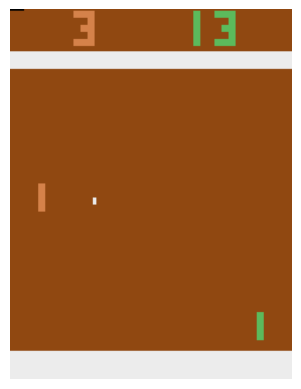

In [14]:
observation, info = env.reset()
policy.init_game(observation)

plt.ion()
plt.axis('off')
img = plt.imshow(env.render())

with tqdm(total=10000) as pbar:
    while True:
        try:
            action = policy(observation)
            observation, reward, terminated, truncated, info = env.step(action)
            render(env)
            policy.update(observation, reward, terminated, truncated, info, pbar)

            if terminated or truncated:
                pbar.update()
                observation, info = env.reset()
                policy.init_game(observation)
                
        except KeyboardInterrupt:
            break
env.close()

In [154]:
policy.save("model.pt")